In [1]:
!pip install torchsummary

# Importing libraries

In [2]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils
import torchvision
from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import roc_auc_score

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'

# Preparing dataset

#### A helper function
For traversing directories and returning each image with the class name

In [3]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)
    
    class_map = {}
    class_distribution = {}
    
    for img_path in root_list:
        class_name = img_path.split(os.sep)[-2]
        
        if class_name not in class_distribution:
            class_distribution[class_name] = 1
        else:
            class_distribution[class_name] +=1
                
    for index, entity in enumerate(class_distribution):
        class_map[entity] = index
    print("Dataset Distribution:\n")
    print(class_distribution)
    print("\n\nClass indices:\n")
    print(class_map)

    data = []
    for img_path in tqdm(root_list):
        class_name = img_path.split(os.sep)[-2]
        data.append([img_path, class_name])
        
    return data, class_map

#### Custom dataset function
For loading images stored in .npy format and creating a dataset

In [4]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_and_labels_list, class_map,transform = None):
        self.data = img_paths_and_labels_list
        self.class_map = class_map
        self.transform = transform
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path, allow_pickle=True)
        img = img.squeeze()
        if class_name == 'axion':
            img = img[0]
        
#         img = np.expand_dims(img, axis = 0)
        
        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']
        
        img = img.to(torch.float)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)

        return img, class_id

**Transforms to be applied to the dataset.
100 x 100 resizing is done for compatibility with the model Efficient - Net b2**

In [5]:
transforms = A.Compose([
#     torchvision.transforms.ToTensor()
    A.CenterCrop(height = 100, width = 100, p=1.0),
        ToTensorV2()
])

In [6]:
data_root_dir = r'/kaggle/input/lensess/dataset/train/*/*'
dataset_img_paths_list, class_map = img_paths_list(data_root_dir)
train_set_image_paths_list=dataset_img_paths_list

Dataset Distribution:

{'no': 10000, 'vort': 10000, 'sphere': 10000}


Class indices:

{'no': 0, 'vort': 1, 'sphere': 2}


  0%|          | 0/30000 [00:00<?, ?it/s]

In [7]:
train_dataset = CustomDataset(train_set_image_paths_list, class_map, transform = transforms)
print(len(train_dataset))

30000


In [8]:
val_root_dir = r'/kaggle/input/lensess/dataset/val/*/*'
val_img_paths_list, val_class_map = img_paths_list(val_root_dir)

Dataset Distribution:

{'no': 2500, 'vort': 2500, 'sphere': 2500}


Class indices:

{'no': 0, 'vort': 1, 'sphere': 2}


  0%|          | 0/7500 [00:00<?, ?it/s]

In [9]:
val_test_dataset = CustomDataset(val_img_paths_list, val_class_map, transform = transforms)
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [0.9, 0.1])
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle = True)

# Creating the model

### What is the model I have chosen and why?
For the common test in DeepLense, we are required to classify a given set of lensing images to the corresponding configuration of dark matter substructure producing the observed lensing effect: vortex, spherical or no substructure. 

I chose **Efficient-Net B2** [1] pretrained architecture as the backbone for my model. 
* EfficientNets [1] were first introduced by two engineers from Google Brain, Mingxing Tan and Quoc V. Le in May 2019.
* They are a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. 
* It scales the model according to the available resources and the input resolution of images. Thus they are a good choice for typical classification problems like this one.

**Model Architecture**
* Firstly features are extracted through the aforementioned backbone which are then passed through a self attention layer. *Attention layers are crucial in capturing important parts of an image and also help in finding out the long range dependencies (in our case, pixels) of the input.*
* The output from the attention layer is then passed through three blocks each comprising of Linear, PReLU (to further add non-linearity in the model), BatchNorm (to prevent the output values from exploding) and Dropout (to prevent overfitting) layers to further fine tune the model.
* Finally a linear layer outputs three values corresponding to each class which are then converted to probabilities using a softmax function (during testing) from which the maximum's label is treated as the final prediction for that image.

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


In [11]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b2',pretrained = pretrained, in_chans = 1)
#         num_in_features = self.model.get_classifier().in_features
        self.attention = SelfAttention(channels=1408, size=4)
    
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1408 * 4 * 4, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(1024, 512),
                                nn.BatchNorm1d(512),
                                nn.PReLU(),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(512, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.3),
                                
                                nn.Linear(128, 3),
#                                 nn.Softmax(dim=1)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
#         print('1',x.shape)
        x = x.view(-1, 1408, 4, 4)
        x = self.attention(x)
#         print('attention',x.shape)
        x = x.reshape(-1, 1408 * 4 * 4)
#         print('2',x.shape)
        x = self.fc(x)
#         print(x)
#         print('3',x.shape)
        return x

#### **A helper function to calculate accuracy**

In [12]:
def calculate_accuracy(y_pred, y_truth):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
    
    correct_preds = (y_pred_labels == y_truth).float()
    acc = correct_preds.sum() / len(correct_preds)
    acc = torch.round(acc*100)
    
    return acc  

#### **Helper functions to train and validate one epoch on the entire training and validation dataset respectively**

In [13]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []
    train_accuracy = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
#         print('x', X.shape)
#         print('hi',y_pred.shape)
        #loss and accuracy calculation
        loss = criterion(y_pred, y_truth)
        accuracy = calculate_accuracy(y_pred, y_truth)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss and accuracy
#         print(f'Partial train loss: {loss.data}')
        train_loss.append(loss.detach().cpu().numpy())
        train_accuracy.append(accuracy.detach().cpu().numpy())
    return model, np.mean(train_loss), np.mean(train_accuracy)

In [14]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []
    val_accuracy = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            val_loss.append(loss.detach().cpu().numpy())
            val_accuracy.append(accuracy.detach().cpu().numpy())
            
    return np.mean(val_loss), np.mean(val_accuracy)

#### **Helper function to train the model for a given number of epochs**

In [15]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    acc_dict = {'train_accuracy':[],'val_accuracy':[]}
    max_val_accuracy = 0
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 15, T_mult = 1,eta_min = 1e-6, verbose=True)
    
#     scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.3,verbose=True)


    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = val_epoch(model, val_loader, criterion)
        scheduler.step()
        if val_accuracy>max_val_accuracy:
            torch.save(model.state_dict(), r'/kaggle/working/lens_model_val.pt')
        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)
        print(f'Train accuracy: {train_accuracy}, Val accuracy:{val_accuracy}')
        acc_dict['train_accuracy'].append(train_accuracy)
        acc_dict['val_accuracy'].append(val_accuracy)
        max_val_accuracy = max(val_accuracy, max_val_accuracy)

    return model, loss_dict, acc_dict

In [16]:
#setting up the required parameters for model training

model = pre_trained_model().to(device)

criterion = nn.CrossEntropyLoss()
EPOCHS = 30
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

summary(model, (1, 100, 100))

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             288
          Identity-2           [-1, 32, 50, 50]               0
              SiLU-3           [-1, 32, 50, 50]               0
    BatchNormAct2d-4           [-1, 32, 50, 50]              64
            Conv2d-5           [-1, 32, 50, 50]             288
          Identity-6           [-1, 32, 50, 50]               0
              SiLU-7           [-1, 32, 50, 50]               0
    BatchNormAct2d-8           [-1, 32, 50, 50]              64
            Conv2d-9              [-1, 8, 1, 1]             264
             SiLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 32, 1, 1]             288
          Sigmoid-12             [-1, 32, 1, 1]               0
    SqueezeExcite-13           [-1, 32, 50, 50]               0
           Conv2d-14           [-1, 16,

### Training the model

In [17]:
model, loss_dict, acc_dict = fit_model(model,criterion,optimizer)

Epoch 00000: adjusting learning rate of group 0 to 3.0000e-04.
Epoch 1/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 2.9673e-04.
Train loss:1.0765528678894043, Val loss:0.8682664632797241
Train accuracy: 42.18336868286133, Val accuracy:59.35544967651367
Epoch 2/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00002: adjusting learning rate of group 0 to 2.8708e-04.
Train loss:0.675823986530304, Val loss:0.4841199517250061
Train accuracy: 70.99040222167969, Val accuracy:81.20378875732422
Epoch 3/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00003: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.4390815198421478, Val loss:0.37677469849586487
Train accuracy: 82.74413299560547, Val accuracy:85.9146957397461
Epoch 4/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00004: adjusting learning rate of group 0 to 2.5054e-04.
Train loss:0.3295690417289734, Val loss:0.3077588677406311
Train accuracy: 87.86673736572266, Val accuracy:89.2654037475586
Epoch 5/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00005: adjusting learning rate of group 0 to 2.2525e-04.
Train loss:0.2608785629272461, Val loss:0.30737853050231934
Train accuracy: 90.8688735961914, Val accuracy:89.05213165283203
Epoch 6/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00006: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.2034977227449417, Val loss:0.2900400757789612
Train accuracy: 93.07782745361328, Val accuracy:89.60663604736328
Epoch 7/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00007: adjusting learning rate of group 0 to 1.6613e-04.
Train loss:0.16017845273017883, Val loss:0.30382949113845825
Train accuracy: 94.5927505493164, Val accuracy:88.42179870605469
Epoch 8/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00008: adjusting learning rate of group 0 to 1.3487e-04.
Train loss:0.13984592258930206, Val loss:0.29303163290023804
Train accuracy: 95.4232406616211, Val accuracy:90.16587829589844
Epoch 9/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00009: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.09620586782693863, Val loss:0.2947084605693817
Train accuracy: 96.7473373413086, Val accuracy:91.38862609863281
Epoch 10/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00010: adjusting learning rate of group 0 to 7.5750e-05.
Train loss:0.0666147992014885, Val loss:0.33695346117019653
Train accuracy: 97.89871978759766, Val accuracy:90.87203979492188
Epoch 11/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00011: adjusting learning rate of group 0 to 5.0465e-05.
Train loss:0.043347522616386414, Val loss:0.36647945642471313
Train accuracy: 98.6087417602539, Val accuracy:91.40758514404297
Epoch 12/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00012: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:0.022415708750486374, Val loss:0.3964793086051941
Train accuracy: 99.35713958740234, Val accuracy:91.36492919921875
Epoch 13/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00013: adjusting learning rate of group 0 to 1.3925e-05.
Train loss:0.01222353894263506, Val loss:0.4208066463470459
Train accuracy: 99.60021209716797, Val accuracy:91.65876770019531
Epoch 14/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00014: adjusting learning rate of group 0 to 4.2669e-06.
Train loss:0.006454386282712221, Val loss:0.4515347480773926
Train accuracy: 99.82089233398438, Val accuracy:91.3507080078125
Epoch 15/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00015: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:0.004721703939139843, Val loss:0.4514896273612976
Train accuracy: 99.88166046142578, Val accuracy:91.63507080078125
Epoch 16/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00016: adjusting learning rate of group 0 to 2.9673e-04.
Train loss:0.4074089229106903, Val loss:0.30440422892570496
Train accuracy: 84.96375274658203, Val accuracy:89.14218139648438
Epoch 17/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00017: adjusting learning rate of group 0 to 2.8708e-04.
Train loss:0.33778679370880127, Val loss:0.45829516649246216
Train accuracy: 88.00746154785156, Val accuracy:82.26066589355469
Epoch 18/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00018: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.3329223394393921, Val loss:0.3140670955181122
Train accuracy: 87.98294067382812, Val accuracy:88.59715270996094
Epoch 19/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00019: adjusting learning rate of group 0 to 2.5054e-04.
Train loss:0.30596235394477844, Val loss:0.29436057806015015
Train accuracy: 89.27398681640625, Val accuracy:89.96682739257812
Epoch 20/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00020: adjusting learning rate of group 0 to 2.2525e-04.
Train loss:0.277127742767334, Val loss:0.2755318284034729
Train accuracy: 90.50426483154297, Val accuracy:90.13744354248047
Epoch 21/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00021: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.2071380913257599, Val loss:0.2548017203807831
Train accuracy: 92.98827362060547, Val accuracy:91.36492919921875
Epoch 22/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00022: adjusting learning rate of group 0 to 1.6613e-04.
Train loss:0.17787538468837738, Val loss:0.28420087695121765
Train accuracy: 94.04051208496094, Val accuracy:89.8862533569336
Epoch 23/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00023: adjusting learning rate of group 0 to 1.3487e-04.
Train loss:0.1656941920518875, Val loss:0.24960681796073914
Train accuracy: 94.49893188476562, Val accuracy:91.56398010253906
Epoch 24/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00024: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.13169991970062256, Val loss:0.2640587091445923
Train accuracy: 95.73880767822266, Val accuracy:91.51184844970703
Epoch 25/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00025: adjusting learning rate of group 0 to 7.5750e-05.
Train loss:0.11069390922784805, Val loss:0.2513815760612488
Train accuracy: 96.41790771484375, Val accuracy:91.84834289550781
Epoch 26/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00026: adjusting learning rate of group 0 to 5.0465e-05.
Train loss:0.0780722051858902, Val loss:0.25177592039108276
Train accuracy: 97.49573516845703, Val accuracy:92.46919250488281
Epoch 27/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00027: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:0.05961166322231293, Val loss:0.2557946443557739
Train accuracy: 98.17377471923828, Val accuracy:92.8151626586914
Epoch 28/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00028: adjusting learning rate of group 0 to 1.3925e-05.
Train loss:0.046691570430994034, Val loss:0.28191715478897095
Train accuracy: 98.63433074951172, Val accuracy:92.52606964111328
Epoch 29/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00029: adjusting learning rate of group 0 to 4.2669e-06.
Train loss:0.03619454801082611, Val loss:0.3105425238609314
Train accuracy: 98.99573516845703, Val accuracy:92.3459701538086
Epoch 30/30:


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

Epoch 00030: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:0.03101445734500885, Val loss:0.30364108085632324
Train accuracy: 99.09808349609375, Val accuracy:92.8104248046875


In [18]:
test_loss, test_accuracy = val_epoch(model, test_loader, criterion)

  0%|          | 0/24 [00:00<?, ?it/s]

In [19]:
print('Testing loss:',test_loss, 'Testing accuracy:',test_accuracy)

Testing loss: 0.2512705 Testing accuracy: 94.25


In [20]:
torch.save(model.state_dict(), r'/kaggle/working/lens_model.pt')

In [21]:
# device = "cuda"

# # Load the checkpoint
# checkpoint = torch.load('/kaggle/input/lenses_att/pytorch/v1/1/lens_model.pt')
# model.load_state_dict(checkpoint)
# model = model.to(device)

**Helper function for testing the model and getting the predicted labels in order to calculate plot ROC (reciever operating characteristic) curve and calculate AUC (area under the curve)**

In [22]:
def get_predictions(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    return all_probs, all_labels

In [23]:
# Get predicted probabilities and true labels
predicted_probs, true_labels = get_predictions(model, test_loader)

# Binarize the true labels
y_true = label_binarize(true_labels, classes=np.arange(predicted_probs.shape[1]))


In [24]:
# Calculate ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(predicted_probs.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



In [25]:
original_labels = ['no substr.', 'vortex substr.', 'spherical substr.']

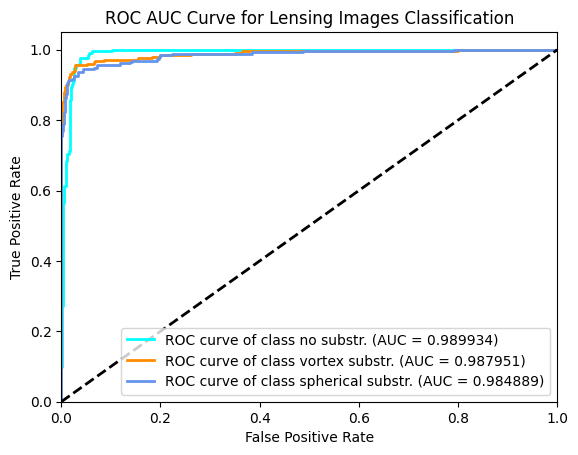

In [26]:
# Plot ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(predicted_probs.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.6f})'
             ''.format(original_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Lensing Images Classification')
plt.legend(loc="lower right")
plt.show()

# References

* [1] Tan, M. and Le, Q.V. (2019) EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. Proceedings of the 36th International Conference on Machine Learning, ICML 2019, Long Beach, 9-15 June 2019, 6105-6114.